### Explore representational similarity, across pairs of preferred features: 
- for each session, grab trials where feat X preferred, and feat Y, compute mean neural activity
- compute cosine sim between mean activity between X and Y. TODO: compare that with computing cosine sim between all pairs, getting dist of cosine sims. depends on which gives better stats...
- compare true cosine sim dist with shuffled dist, using session permutation

In [21]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.pseudo_decoding.belief_partitions.belief_partition_configs import *
import scripts.pseudo_decoding.belief_partitions.belief_partitions_io as belief_partitions_io

import scipy
import argparse
import copy
import itertools

from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
def get_pseudo_frs_for_session(session, args, num_pseudo=100):
    # for grabbing behavior and firing rates, use subject-specific arguments
    # for grabbing decoder weights, use general
    sub_args = copy.deepcopy(args)
    sub_args.subject = behavioral_utils.get_sub_for_session(session)
    print(sub_args.feat)
    beh = behavioral_utils.load_behavior_from_args(session, sub_args)
    beh = behavioral_utils.get_feat_choice_label(beh, sub_args.feat)
    beh = behavioral_utils.get_belief_partitions(beh, sub_args.feat, use_x=True)

    sub_beh = beh[beh.BeliefPartition == "High X"]

    frs = spike_utils.get_frs_from_args(sub_args, session)
    frs["TimeIdx"] = (frs["Time"] * 10).round().astype(int)

    sub_frs = frs[frs.TrialNumber.isin(sub_beh.TrialNumber)]

    rng = np.random.default_rng()
    trial_nums = rng.choice(sub_frs.TrialNumber.unique(), num_pseudo)
    pseudo_trials = pd.DataFrame({"TrialNumber": trial_nums, "PseudoTrialNumber": list(range(num_pseudo))})
    pseudo_frs = pd.merge(sub_frs, pseudo_trials, on="TrialNumber")
    pseudo_frs["session"] = session
    return pseudo_frs

def get_sims(pair, args):
    (feat1, feat2) = pair.pair
    args.feat = feat1
    feat1_res = pd.concat(pd.Series(pair.sessions).apply(lambda x: get_pseudo_frs_for_session(x, args)).values)

    args.feat = feat2
    feat2_res = pd.concat(pd.Series(pair.sessions).apply(lambda x: get_pseudo_frs_for_session(x, args)).values)

    merged = pd.merge(feat1_res, feat2_res, on=["PseudoUnitID", "PseudoTrialNumber", "TimeIdx"], suffixes=["_feat1", "_feat2"], how="outer").fillna(0)

    sims = merged.groupby(["PseudoTrialNumber", "TimeIdx"]).apply(lambda x: classifier_utils.cosine_sim(x.FiringRate_feat1, x.FiringRate_feat2)).reset_index(name="cosine_sim")
    return sims

In [23]:
BOTH_PAIRS_PATH = "/data/patrick_res/sessions/both/pairs_at_least_3blocks_10sess.pickle"
pairs = pd.read_pickle(BOTH_PAIRS_PATH).reset_index(drop=True)
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.subject = "both"
args.mode = "pref"
# args.sig_unit_level = "belief_partition_95th"
# args.sig_unit_level = "pref_99th_window_filter_drift"
args.trial_event = "StimOnset"
args.trial_interval = get_trial_interval(args.trial_event)

pair = pairs.iloc[2]
args.all_sessions = pd.DataFrame({"session_name": pair.sessions})


true_sims = get_sims(pair, args)

shuffle_sims = []
for i in tqdm(range(10)):
    args.shuffle_idx = i
    shuffle_sim = get_sims(pair, args)
    shuffle_sim["shuffle_idx"] = i
    shuffle_sims.append(shuffle_sim)
shuffle_sims = pd.concat(shuffle_sims)



    

CIRCLE
CIRCLE
CIRCLE
CIRCLE
CIRCLE
CIRCLE
CIRCLE
CIRCLE
CIRCLE
CIRCLE
CIRCLE
GREEN
GREEN
GREEN
GREEN
GREEN
GREEN
GREEN
GREEN
GREEN
GREEN
GREEN


  0%|          | 0/10 [00:00<?, ?it/s]

CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
GREEN
Session permutation shuffle set, randomly choosing from 10 other sessions
GREEN
Session permutation shu

 10%|█         | 1/10 [00:07<01:05,  7.28s/it]

CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
GREEN
Session permutation shuffle set, randomly choosing from 10 other sessions
GREEN
Session permutation shu

 20%|██        | 2/10 [00:14<00:55,  6.97s/it]

CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
GREEN
Session permutation shuffle set, randomly choosing from 10 other sessions
GREEN
Session permutation shu

 30%|███       | 3/10 [00:21<00:48,  7.00s/it]

CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
GREEN
Session permutation shuffle set, randomly choosing from 10 other sessions
GREEN
Session permutation shu

 40%|████      | 4/10 [00:27<00:41,  6.93s/it]

CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
GREEN
Session permutation shuffle set, randomly choosing from 10 other sessions
GREEN
Session permutation shu

 50%|█████     | 5/10 [00:34<00:34,  6.91s/it]

CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
GREEN
Session permutation shuffle set, randomly choosing from 10 other sessions
GREEN
Session permutation shu

 60%|██████    | 6/10 [00:41<00:27,  6.85s/it]

CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
GREEN
Session permutation shuffle set, randomly choosing from 10 other sessions
GREEN
Session permutation shu

 70%|███████   | 7/10 [00:48<00:20,  6.84s/it]

CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
GREEN
Session permutation shuffle set, randomly choosing from 10 other sessions
GREEN
Session permutation shu

 80%|████████  | 8/10 [00:55<00:13,  6.87s/it]

CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
GREEN
Session permutation shuffle set, randomly choosing from 10 other sessions
GREEN
Session permutation shu

 90%|█████████ | 9/10 [01:02<00:06,  6.86s/it]

CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
CIRCLE
Session permutation shuffle set, randomly choosing from 10 other sessions
GREEN
Session permutation shuffle set, randomly choosing from 10 other sessions
GREEN
Session permutation shu

100%|██████████| 10/10 [01:09<00:00,  6.92s/it]


In [24]:
pairs

,pair,sessions,num_sessions,dim_type,n_units
0,"[CIRCLE, SQUARE]","[20180615, 20180709, 20180802, 20180803, 20180...",14,within dim,415
1,"[CIRCLE, STAR]","[20180709, 20180803, 20180821, 20180911, 20180...",12,within dim,297
2,"[CIRCLE, GREEN]","[20180802, 20180806, 20180808, 20180813, 20180...",11,across dim,303
3,"[CIRCLE, MAGENTA]","[20180802, 20180803, 20180806, 20180808, 20180...",10,across dim,280
4,"[CIRCLE, YELLOW]","[20180802, 20180810, 20180813, 20180821, 20180...",14,across dim,351
5,"[CIRCLE, RIPPLE]","[20180615, 20180802, 20180803, 20180810, 20180...",10,across dim,269
6,"[SQUARE, CYAN]","[20180801, 20180802, 20180803, 20180820, 20180...",12,across dim,355
7,"[SQUARE, GREEN]","[20180802, 20180806, 20180808, 20180830, 20180...",10,across dim,273
8,"[SQUARE, MAGENTA]","[20180801, 20180802, 20180803, 20180806, 20180...",13,across dim,354
9,"[SQUARE, YELLOW]","[20180801, 20180802, 20180810, 20180820, 20180...",13,across dim,339


In [25]:
shuffle_sims.cosine_sim.mean()

0.780696973011187

In [26]:
true_sims.cosine_sim.mean()

0.775831163311343

<Axes: xlabel='TimeIdx', ylabel='cosine_sim'>

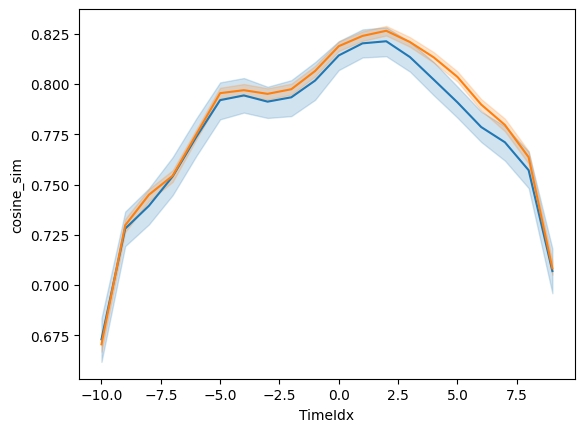

In [27]:
fig, ax = plt.subplots()
sns.lineplot(true_sims, x="TimeIdx", y="cosine_sim", ax=ax)
sns.lineplot(shuffle_sims, x="TimeIdx", y="cosine_sim", ax=ax)
